In [284]:
import pandas as pd
import numpy as np

class ForexIndicators:
    """Minimalist forex technical indicators calculator."""
    
    def __init__(self, df: pd.DataFrame):
        """
        Args:
            df: DataFrame with columns: Open, High, Low, Close, Volume
        """
        self.df = df.copy()
        self.o = df['Open']
        self.h = df['High']
        self.l = df['Low']
        self.c = df['Close']
        self.v = df.get('Vol', pd.Series(0, index=df.index))
    
    # === TREND ===
    def sma(self, period: int = 20) -> pd.Series:
        return self.c.rolling(period).mean()
    
    def ema(self, period: int = 20) -> pd.Series:
        return self.c.ewm(span=period, adjust=False).mean()
    
    def macd(self, fast: int = 12, slow: int = 26, signal: int = 9) -> pd.DataFrame:
        ema_fast = self.c.ewm(span=fast, adjust=False).mean()
        ema_slow = self.c.ewm(span=slow, adjust=False).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal, adjust=False).mean()
        histogram = macd_line - signal_line
        return pd.DataFrame({'macd': macd_line, 'signal': signal_line, 'histogram': histogram})
    
    # === MOMENTUM ===
    def rsi(self, period: int = 14) -> pd.Series:
        delta = self.c.diff()
        gain = delta.where(delta > 0, 0).rolling(period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
        rs = gain / loss
        return (100. - (100. / (1. + rs)))/100.
    
    def stochastic(self, k_period: int = 14, d_period: int = 3) -> pd.DataFrame:
        lowest_low = self.l.rolling(k_period).min()
        highest_high = self.h.rolling(k_period).max()
        k =  (self.c - lowest_low) / (highest_high - lowest_low)
        d = k.rolling(d_period).mean()
        return pd.DataFrame({'%K': k, '%D': d})
    
    def momentum(self, period: int = 10) -> pd.Series:
        return self.c.diff(period)
    
    # === VOLATILITY ===
    def bollinger_bands(self, period: int = 20, std_dev: float = 2) -> pd.DataFrame:
        sma = self.c.rolling(period).mean()
        std = self.c.rolling(period).std()
        return pd.DataFrame({
            'upper': sma + (std * std_dev),
            'middle': sma,
            'lower': sma - (std * std_dev)
        })
    
    def atr(self, period: int = 14) -> pd.Series:
        tr = pd.concat([
            self.h - self.l,
            (self.h - self.c.shift()).abs(),
            (self.l - self.c.shift()).abs()
        ], axis=1).max(axis=1)
        return tr.rolling(period).mean()
    
    # === VOLUME ===
    def obv(self) -> pd.Series:
        direction = np.sign(self.c.diff())
        return (self.v * direction).cumsum()
    
    def vwap(self) -> pd.Series:
        typical_price = (self.h + self.l + self.c) / 3
        return (typical_price * self.v).cumsum() / self.v.cumsum()
    
    # === ADX (TREND STRENGTH) ===
    def adx(self, period: int = 14) -> pd.DataFrame:
        tr = pd.concat([
            self.h - self.l,
            (self.h - self.c.shift()).abs(),
            (self.l - self.c.shift()).abs()
        ], axis=1).max(axis=1)
        
        plus_dm = self.h.diff()
        minus_dm = -self.l.diff()
        plus_dm = plus_dm.where((plus_dm > minus_dm) & (plus_dm > 0), 0)
        minus_dm = minus_dm.where((minus_dm > plus_dm) & (minus_dm > 0), 0)
        
        atr = tr.ewm(span=period, adjust=False).mean()
        plus_di = 100 * (plus_dm.ewm(span=period, adjust=False).mean() / atr)
        minus_di = 100 * (minus_dm.ewm(span=period, adjust=False).mean() / atr)
        
        dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
        adx = dx.ewm(span=period, adjust=False).mean()
        
        return pd.DataFrame({'+DI': plus_di, '-DI': minus_di, 'ADX': adx})
    
    # === CONVENIENCE ===
    def add_all(self) -> pd.DataFrame:
        """Add all indicators to dataframe."""
        result = self.df.copy()
        
        # Trend
        result['SMA_20'] = self.sma(20)
        result['EMA_20'] = self.ema(20)
        macd = self.macd()
        result = pd.concat([result, macd.add_prefix('MACD_')], axis=1)
        
        # Momentum
        result['RSI_14'] = self.rsi(14)
        stoch = self.stochastic()
        result = pd.concat([result, stoch.add_prefix('STOCH_')], axis=1)
        
        # Volatility
        bb = self.bollinger_bands()
        result = pd.concat([result, bb.add_prefix('BB_')], axis=1)
        result['ATR_14'] = self.atr(14)
        
        # Trend strength
        adx = self.adx()
        result = pd.concat([result, adx.add_prefix('ADX_')], axis=1)
        
        return result



In [285]:
# === USAGE ===
if __name__ == "__main__":
    # Assuming df already exists with OHLC data
    df = pd.read_csv('USDJPY_H4.csv')
    
    indicators = ForexIndicators(df)
    
    # Individual indicators
    rsi = indicators.rsi(14)
    macd = indicators.macd()
    bb = indicators.bollinger_bands()
    
    # Or add all at once
    df_with_indicators = indicators.add_all()

In [286]:
df_with_indicators.iloc[:, -10:]  # Display last 10 columns with indicators

,RSI_14,STOCH_%K,STOCH_%D,BB_upper,BB_middle,BB_lower,ATR_14,ADX_+DI,ADX_-DI,ADX_ADX
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.466552,0.000000,100.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.476947,0.000000,100.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.744381,0.000000,100.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.545309,1.143975,98.172120
...,...,...,...,...,...,...,...,...,...,...
13986,0.674306,0.791897,0.728054,115.249639,114.95765,114.665661,0.148143,18.568383,14.266485,19.615493
13987,0.687574,0.832413,0.783303,115.267564,114.96950,114.671436,0.150071,20.551282,12.131434,20.435079
13988,0.648030,0.808471,0.810927,115.281426,114.98105,114.680674,0.145214,18.957054,11.190360,21.145387
13989,0.520974,0.666667,0.769184,115.279618,114.99315,114.706682,0.148857,15.468088,16.142089,18.610299


In [287]:
df_with_indicators.to_csv('USDJPY_H4_with_indicators.csv', index=False)

In [288]:
df_new = df_with_indicators.copy().iloc[20:-20,:]  # Remove first 20 and last 20 rows

In [289]:
df_new.head()

,Date,Time,Open,High,Low,Close,Tick,Vol,Spread,SMA_20,...,RSI_14,STOCH_%K,STOCH_%D,BB_upper,BB_middle,BB_lower,ATR_14,ADX_+DI,ADX_-DI,ADX_ADX
20,2013.01.07,4:00:00,88.054,88.172,87.682,87.776,15805,0.0,5,87.47755,...,0.573905,0.619951,0.750714,88.353561,87.47755,86.601539,0.383000,21.608311,14.988387,53.500638
21,2013.01.07,8:00:00,87.777,87.906,87.621,87.874,19020,0.0,5,87.51380,...,0.600454,0.679927,0.696450,88.392564,87.51380,86.635036,0.384429,19.446532,15.630181,47.817888
22,2013.01.07,12:00:00,87.877,87.955,87.716,87.778,17750,0.0,5,87.54090,...,0.585281,0.621175,0.640351,88.417018,87.54090,86.664782,0.392286,19.539695,14.250665,43.529167
23,2013.01.07,16:00:00,87.779,87.872,87.651,87.685,16682,0.0,5,87.57360,...,0.635024,0.564259,0.621787,88.417825,87.57360,86.729375,0.378286,17.858034,15.555488,38.644086
24,2013.01.07,20:00:00,87.685,87.843,87.351,87.456,10560,0.0,9,87.58620,...,0.580687,0.405559,0.530331,88.414572,87.58620,86.757828,0.391071,14.624834,23.778807,36.669703


In [290]:
import matplotlib.pyplot as plt

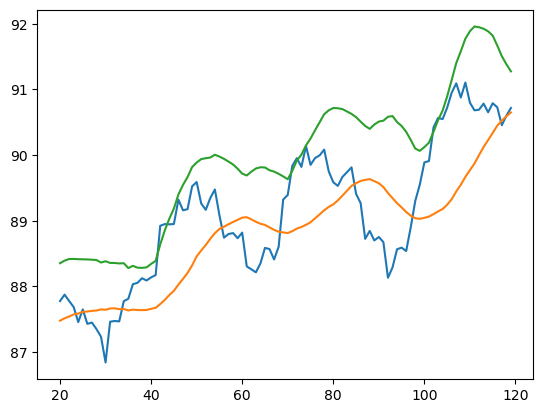

In [291]:
plt.plot(df_new['Close'].iloc[:100], label='Close Price')
plt.plot(df_new['SMA_20'].iloc[:100], label='SMA 20')
plt.plot(df_new['BB_upper'].iloc[:100], label='Bollinger Upper Band')

In [292]:
test_df = df_new.copy().iloc[:200]

In [293]:
def standardize(x):
    return (x - x.mean()) / x.std()

In [294]:
# create standardized versions of the OHLC columns of test_df
test_df['Open_st'] = standardize(test_df['Open'])
test_df['High_st'] = standardize(test_df['High'])
test_df['Low_st'] = standardize(test_df['Low'])
test_df['Close_st'] = standardize(test_df['Close'])


In [295]:
test_df.head()

,Date,Time,Open,High,Low,Close,Tick,Vol,Spread,SMA_20,...,BB_middle,BB_lower,ATR_14,ADX_+DI,ADX_-DI,ADX_ADX,Open_st,High_st,Low_st,Close_st
20,2013.01.07,4:00:00,88.054,88.172,87.682,87.776,15805,0.0,5,87.47755,...,87.47755,86.601539,0.383000,21.608311,14.988387,53.500638,-1.359351,-1.397042,-1.441217,-1.500052
21,2013.01.07,8:00:00,87.777,87.906,87.621,87.874,19020,0.0,5,87.51380,...,87.51380,86.635036,0.384429,19.446532,15.630181,47.817888,-1.485946,-1.518611,-1.469221,-1.455146
22,2013.01.07,12:00:00,87.877,87.955,87.716,87.778,17750,0.0,5,87.54090,...,87.54090,86.664782,0.392286,19.539695,14.250665,43.529167,-1.440244,-1.496217,-1.425608,-1.499136
23,2013.01.07,16:00:00,87.779,87.872,87.651,87.685,16682,0.0,5,87.57360,...,87.57360,86.729375,0.378286,17.858034,15.555488,38.644086,-1.485032,-1.534150,-1.455448,-1.541751
24,2013.01.07,20:00:00,87.685,87.843,87.351,87.456,10560,0.0,9,87.58620,...,87.58620,86.757828,0.391071,14.624834,23.778807,36.669703,-1.527992,-1.547403,-1.593172,-1.646685


In [296]:
data1 = test_df.iloc[:10]
data1

,Date,Time,Open,High,Low,Close,Tick,Vol,Spread,SMA_20,...,BB_middle,BB_lower,ATR_14,ADX_+DI,ADX_-DI,ADX_ADX,Open_st,High_st,Low_st,Close_st
20,2013.01.07,4:00:00,88.054,88.172,87.682,87.776,15805,0.0,5,87.47755,...,87.47755,86.601539,0.383000,21.608311,14.988387,53.500638,-1.359351,-1.397042,-1.441217,-1.500052
21,2013.01.07,8:00:00,87.777,87.906,87.621,87.874,19020,0.0,5,87.51380,...,87.51380,86.635036,0.384429,19.446532,15.630181,47.817888,-1.485946,-1.518611,-1.469221,-1.455146
22,2013.01.07,12:00:00,87.877,87.955,87.716,87.778,17750,0.0,5,87.54090,...,87.54090,86.664782,0.392286,19.539695,14.250665,43.529167,-1.440244,-1.496217,-1.425608,-1.499136
23,2013.01.07,16:00:00,87.779,87.872,87.651,87.685,16682,0.0,5,87.57360,...,87.57360,86.729375,0.378286,17.858034,15.555488,38.644086,-1.485032,-1.534150,-1.455448,-1.541751
24,2013.01.07,20:00:00,87.685,87.843,87.351,87.456,10560,0.0,9,87.58620,...,87.58620,86.757828,0.391071,14.624834,23.778807,36.669703,-1.527992,-1.547403,-1.593172,-1.646685
25,2013.01.08,0:00:00,87.457,87.788,87.236,87.649,17203,0.0,15,87.61230,...,87.61230,86.812444,0.410857,11.847918,23.219530,36.104120,-1.632194,-1.572540,-1.645966,-1.558247
26,2013.01.08,4:00:00,87.651,87.670,87.328,87.429,14986,0.0,5,87.61755,...,87.61755,86.824311,0.400714,10.431896,20.444413,35.613948,-1.543531,-1.626469,-1.603731,-1.659058
27,2013.01.08,8:00:00,87.427,87.490,87.334,87.449,16990,0.0,5,87.62730,...,87.62730,86.848208,0.385929,9.814528,19.234497,35.189132,-1.645904,-1.708733,-1.600976,-1.649893
28,2013.01.08,12:00:00,87.450,87.584,87.304,87.350,18376,0.0,5,87.63290,...,87.63290,86.864047,0.397714,12.408353,17.134436,32.630237,-1.635393,-1.665773,-1.614748,-1.695258
29,2013.01.08,16:00:00,87.350,87.360,86.980,87.234,18636,0.0,5,87.64975,...,87.64975,86.936008,0.382143,10.596629,27.081805,34.113176,-1.681095,-1.768146,-1.763490,-1.748412


<BarContainer object of 200 artists>

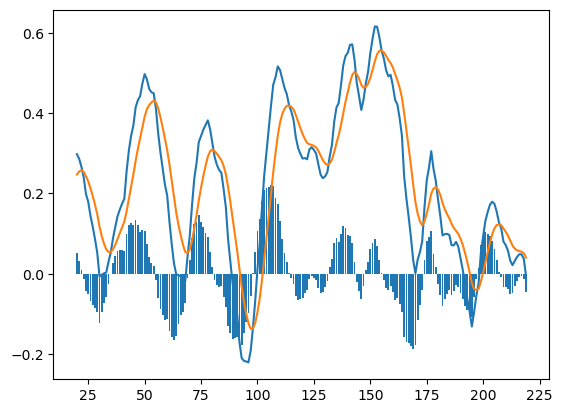

In [297]:
plt.plot(test_df['MACD_macd'], label='MACD Line')
plt.plot(test_df['MACD_signal'], label='Signal Line')
plt.bar(test_df.index, test_df['MACD_histogram'], label='Histogram')

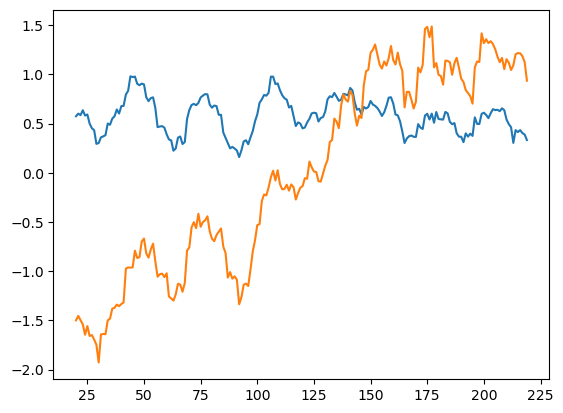

In [298]:
plt.plot(test_df['RSI_14'], label='RSI 14')
#plt.plot(test_df['MACD_macd'], label='MACD Line')
#plt.plot(test_df['MACD_signal'], label='Signal Line')
plt.plot(test_df['Close_st'], label='Standardized Close Price')

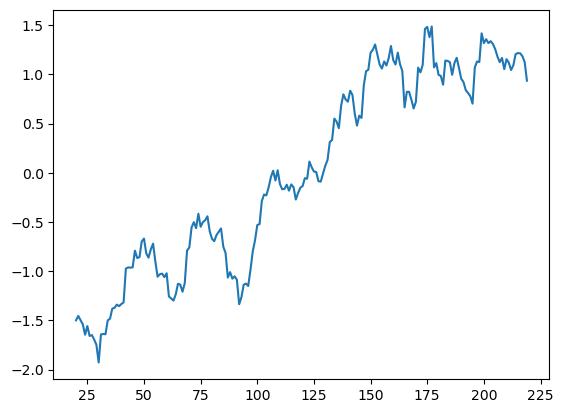

In [299]:
plt.plot(test_df['Close_st'], label='Standardized Close Price')


In [ ]:
# create a class to generate training data for forex price prediction models
class ForexDataGenerator:
    def __init__(self, df: pd.DataFrame, window_size: int = 50):
        self.df = df
        self.window_size = window_size
        self.output_df = df.copy().iloc[:-self.window_size-1,:]  
    
    def generate_sequences(self,pip=0.) -> tuple:
        sequences = []
        labels = []
        close = self.df['Close'].values
        for i in range(len(self.df) - self.window_size - 1):
            seq = close[i:i + self.window_size]
            next_val = close[i + self.window_size]
            last_val = seq[0]
            label = 1 if next_val > last_val + pip else 0  # 1: up, 0: not up
            print(f"Current val: {last_val}, Next val: {next_val}, Label: {label}")
            sequences.append(seq)
            labels.append(label)
        print(f"Output df shape before trimming: {self.output_df.shape}")
        print(f"Generated {len(sequences)} sequences of window size {self.window_size}.")
        self.output_df['Label'] = labels

        return self.output_df  # return the output df with labels

In [301]:
data = ForexDataGenerator(test_df,window_size=10)
new_df = data.generate_sequences(pip=0.)

Next val: 86.841, Last val: 87.776, Label: 0
Next val: 87.462, Last val: 87.874, Label: 0
Next val: 87.473, Last val: 87.778, Label: 0
Next val: 87.467, Last val: 87.685, Label: 0
Next val: 87.775, Last val: 87.456, Label: 1
Next val: 87.812, Last val: 87.649, Label: 1
Next val: 88.034, Last val: 87.429, Label: 1
Next val: 88.054, Last val: 87.449, Label: 1
Next val: 88.124, Last val: 87.35, Label: 1
Next val: 88.09, Last val: 87.234, Label: 1
Next val: 88.137, Last val: 86.841, Label: 1
Next val: 88.173, Last val: 87.462, Label: 1
Next val: 88.923, Last val: 87.473, Label: 1
Next val: 88.949, Last val: 87.467, Label: 1
Next val: 88.945, Last val: 87.775, Label: 1
Next val: 88.95, Last val: 87.812, Label: 1
Next val: 89.321, Last val: 88.034, Label: 1
Next val: 89.159, Last val: 88.054, Label: 1
Next val: 89.176, Last val: 88.124, Label: 1
Next val: 89.524, Last val: 88.09, Label: 1
Next val: 89.589, Last val: 88.137, Label: 1
Next val: 89.263, Last val: 88.173, Label: 1
Next val: 89.1

In [302]:
new_df.head()

,Date,Time,Open,High,Low,Close,Tick,Vol,Spread,SMA_20,...,BB_lower,ATR_14,ADX_+DI,ADX_-DI,ADX_ADX,Open_st,High_st,Low_st,Close_st,Label
20,2013.01.07,4:00:00,88.054,88.172,87.682,87.776,15805,0.0,5,87.47755,...,86.601539,0.383000,21.608311,14.988387,53.500638,-1.359351,-1.397042,-1.441217,-1.500052,0
21,2013.01.07,8:00:00,87.777,87.906,87.621,87.874,19020,0.0,5,87.51380,...,86.635036,0.384429,19.446532,15.630181,47.817888,-1.485946,-1.518611,-1.469221,-1.455146,0
22,2013.01.07,12:00:00,87.877,87.955,87.716,87.778,17750,0.0,5,87.54090,...,86.664782,0.392286,19.539695,14.250665,43.529167,-1.440244,-1.496217,-1.425608,-1.499136,0
23,2013.01.07,16:00:00,87.779,87.872,87.651,87.685,16682,0.0,5,87.57360,...,86.729375,0.378286,17.858034,15.555488,38.644086,-1.485032,-1.534150,-1.455448,-1.541751,0
24,2013.01.07,20:00:00,87.685,87.843,87.351,87.456,10560,0.0,9,87.58620,...,86.757828,0.391071,14.624834,23.778807,36.669703,-1.527992,-1.547403,-1.593172,-1.646685,1


In [303]:
new_df.to_csv('forex_sequences.csv', index=False)